# Word Embeddings

- The state-of-art of vectorizing texts is to learn the numeric representations of words using deep learning methods.
- These deep-learning based numeric representations of linguistic units are commonly referred to as **embeddings**.
- Word embeddings can be learned either along with the target NLP task (e.g., the `Embedding` layer in RNN Language Model) or via an **unsupervised** method based on a large number of texts.
- In this tutorial, we will look at two main algorithms in `word2vec` that allow us to learn the word embeddings in an **unsupervised** manner from a large collection of texts.

- Strengths of word embeddings
    - They can be learned using **unsupervised** methods.
    - They include quite a proportion of the lexical **semantics**.
    - They can be learned by **batch**. We don't have to process the entire corpus and create the word-by-document matrix for vectorization. 
    - Therefore, it is less likely to run into the **memory** capacity issue for huge corpora.

## Overview

### What is `word2vec`?

- `Word2vec` is one of the most popular techniques to learn word embeddings using a two-layer neural network.
- The input is a **text corpus** and the output is a set of **word vectors**.
- Research has shown that these embeddings include rich semantic information of words, which allow us to perform interesting **semantic computation** (See Mikolov et al's works in References).

### Basis of Word Embeddings: Distributional Semantics

- "*You shall know a word by the company it keeps*" (Firth, 1975).
- Word distributions show a considerable amount of **lexical semantics**.
- Construction/Pattern distributions show a considerable amount of the **constructional semantics**.
- Semantics of linguistic units are implicitly or explicitly embedded in their distributions (i.e., *occurrences* and *co-occurrences*) in language use (**Distributional Semantics**).

### Main training algorithms of `word2vec`

- Continuous Bag-of-Words (**CBOW**): The general language modeling task for embeddings training is to learn a model that is capable of using the ***context*** words to predict a ***target*** word.
- **Skip-Gram**: The general language modeling task for embeddings training is to learn a model that is capable of using a ***target word*** to predict its context words.

![](../images/word2vec.png)

- Other variants of embeddings training:
  - `fasttext` from Facebook
  - `GloVe` from Stanford NLP Group
- There are many ways to train work embeddings.
  - `gensim`: Simplest and straightforward implementation of `word2vec`.
  - Training based on deep learning packages (e.g., `keras`, `tensorflow`)
  - `spacy` (It comes with the pre-trained embeddings models, using GloVe.)
- See Sarkar (2019), Chapter 4, for more comprehensive reviews.

### An Intuitive Understanding of CBOW

![](../images/word2vec-text-to-sequences.gif)

![](../images/word2vec-cbow.gif)

### An Intuitive Understanding of Skip-gram

![](../images/word2vec-skipgram.gif)

## Import necessary dependencies and settings

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
pd.options.display.max_colwidth = 200

In [2]:
# # Google Colab Adhoc Setting
# !nvidia-smi
# nltk.download(['gutenberg','punkt','stopwords'])
# !pip show spacy
# !pip install --upgrade spacy
# #!python -m spacy download en_core_web_trf
# !python -m spacy download en_core_web_lg

## Sample Corpus: A Naive Example

In [3]:
corpus = [
    'The sky is blue and beautiful.', 'Love this blue and beautiful sky!',
    'The quick brown fox jumps over the lazy dog.',
    "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
    'I love green eggs, ham, sausages and bacon!',
    'The brown fox is quick and the blue dog is lazy!',
    'The sky is very blue and the sky is very beautiful today',
    'The dog is lazy but the brown fox is quick!'
]
labels = [
    'weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather',
    'animals'
]

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


### Simple text pre-processing

- Usually for unsupervised `word2vec` learning, we don't really need much text preprocessing.
- So we keep our preprocessing to the minimum.
    - Remove only symbols/punctuations, as well as redundant whitespaces.
    - Perform word tokenization, which would also determine the base units for embeddings learning.


### Suggestions

- If you are using `keras` to build the network for embeddings training, please prepare your input corpus data for `Tokenizer()`in the format where each **token** is delimited by a **whitespace**.
- If you are using `gensim` to train word embeddings, please tokenize your corpus data first. That is, the `gensim` only requires a tokenized version of the corpus and it will learn the word embeddings for you. 

In [4]:
wpt = nltk.WordPunctTokenizer()
# stop_words = nltk.corpus.stopwords.words('english')
def preprocess_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    doc = ' '.join(tokens)
    return doc

corpus_norm = [preprocess_document(text) for text in corpus]
corpus_tokens = [preprocess_document(text).split(' ') for text in corpus]

In [5]:
print(corpus_norm)
print(corpus_tokens)

['the sky is blue and beautiful', 'love this blue and beautiful sky', 'the quick brown fox jumps over the lazy dog', 'a kings breakfast has sausages ham bacon eggs toast and beans', 'i love green eggs ham sausages and bacon', 'the brown fox is quick and the blue dog is lazy', 'the sky is very blue and the sky is very beautiful today', 'the dog is lazy but the brown fox is quick']
[['the', 'sky', 'is', 'blue', 'and', 'beautiful'], ['love', 'this', 'blue', 'and', 'beautiful', 'sky'], ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'], ['a', 'kings', 'breakfast', 'has', 'sausages', 'ham', 'bacon', 'eggs', 'toast', 'and', 'beans'], ['i', 'love', 'green', 'eggs', 'ham', 'sausages', 'and', 'bacon'], ['the', 'brown', 'fox', 'is', 'quick', 'and', 'the', 'blue', 'dog', 'is', 'lazy'], ['the', 'sky', 'is', 'very', 'blue', 'and', 'the', 'sky', 'is', 'very', 'beautiful', 'today'], ['the', 'dog', 'is', 'lazy', 'but', 'the', 'brown', 'fox', 'is', 'quick']]


### Training Embeddings Using word2vec

- The expected inputs of `gensim.model.word2vec` is token-based corpus object.

In [6]:
%%time

from gensim.models import word2vec

# Set values for various parameters
feature_size = 10  
window_context = 5  
min_word_count = 1  

w2v_model = word2vec.Word2Vec(
    corpus_tokens,
    size=feature_size,        # Word embeddings dimensionality
    window=window_context,    # Context window size
    min_count=min_word_count, # Minimum word count
    sg=1,                     # `1` for skip-gram; otherwise CBOW.
    seed = 123,               # random seed
    workers=1,                # number of cores to use
    negative = 5,             # how many negative samples should be drawn
    cbow_mean = 1,            # whether to use the average of context word embeddings or sum(concat)
    iter=100,                 # number of epochs for the entire corpus
    batch_words=10000,        # batch size
)

CPU times: user 251 ms, sys: 79.8 ms, total: 331 ms
Wall time: 327 ms


### Visualizing Word Embeddings

- Embeddings represent words in multidimensional space.
- We can inspect the quality of embeddings using dimensional reduction and visualize words in a 2D plot.

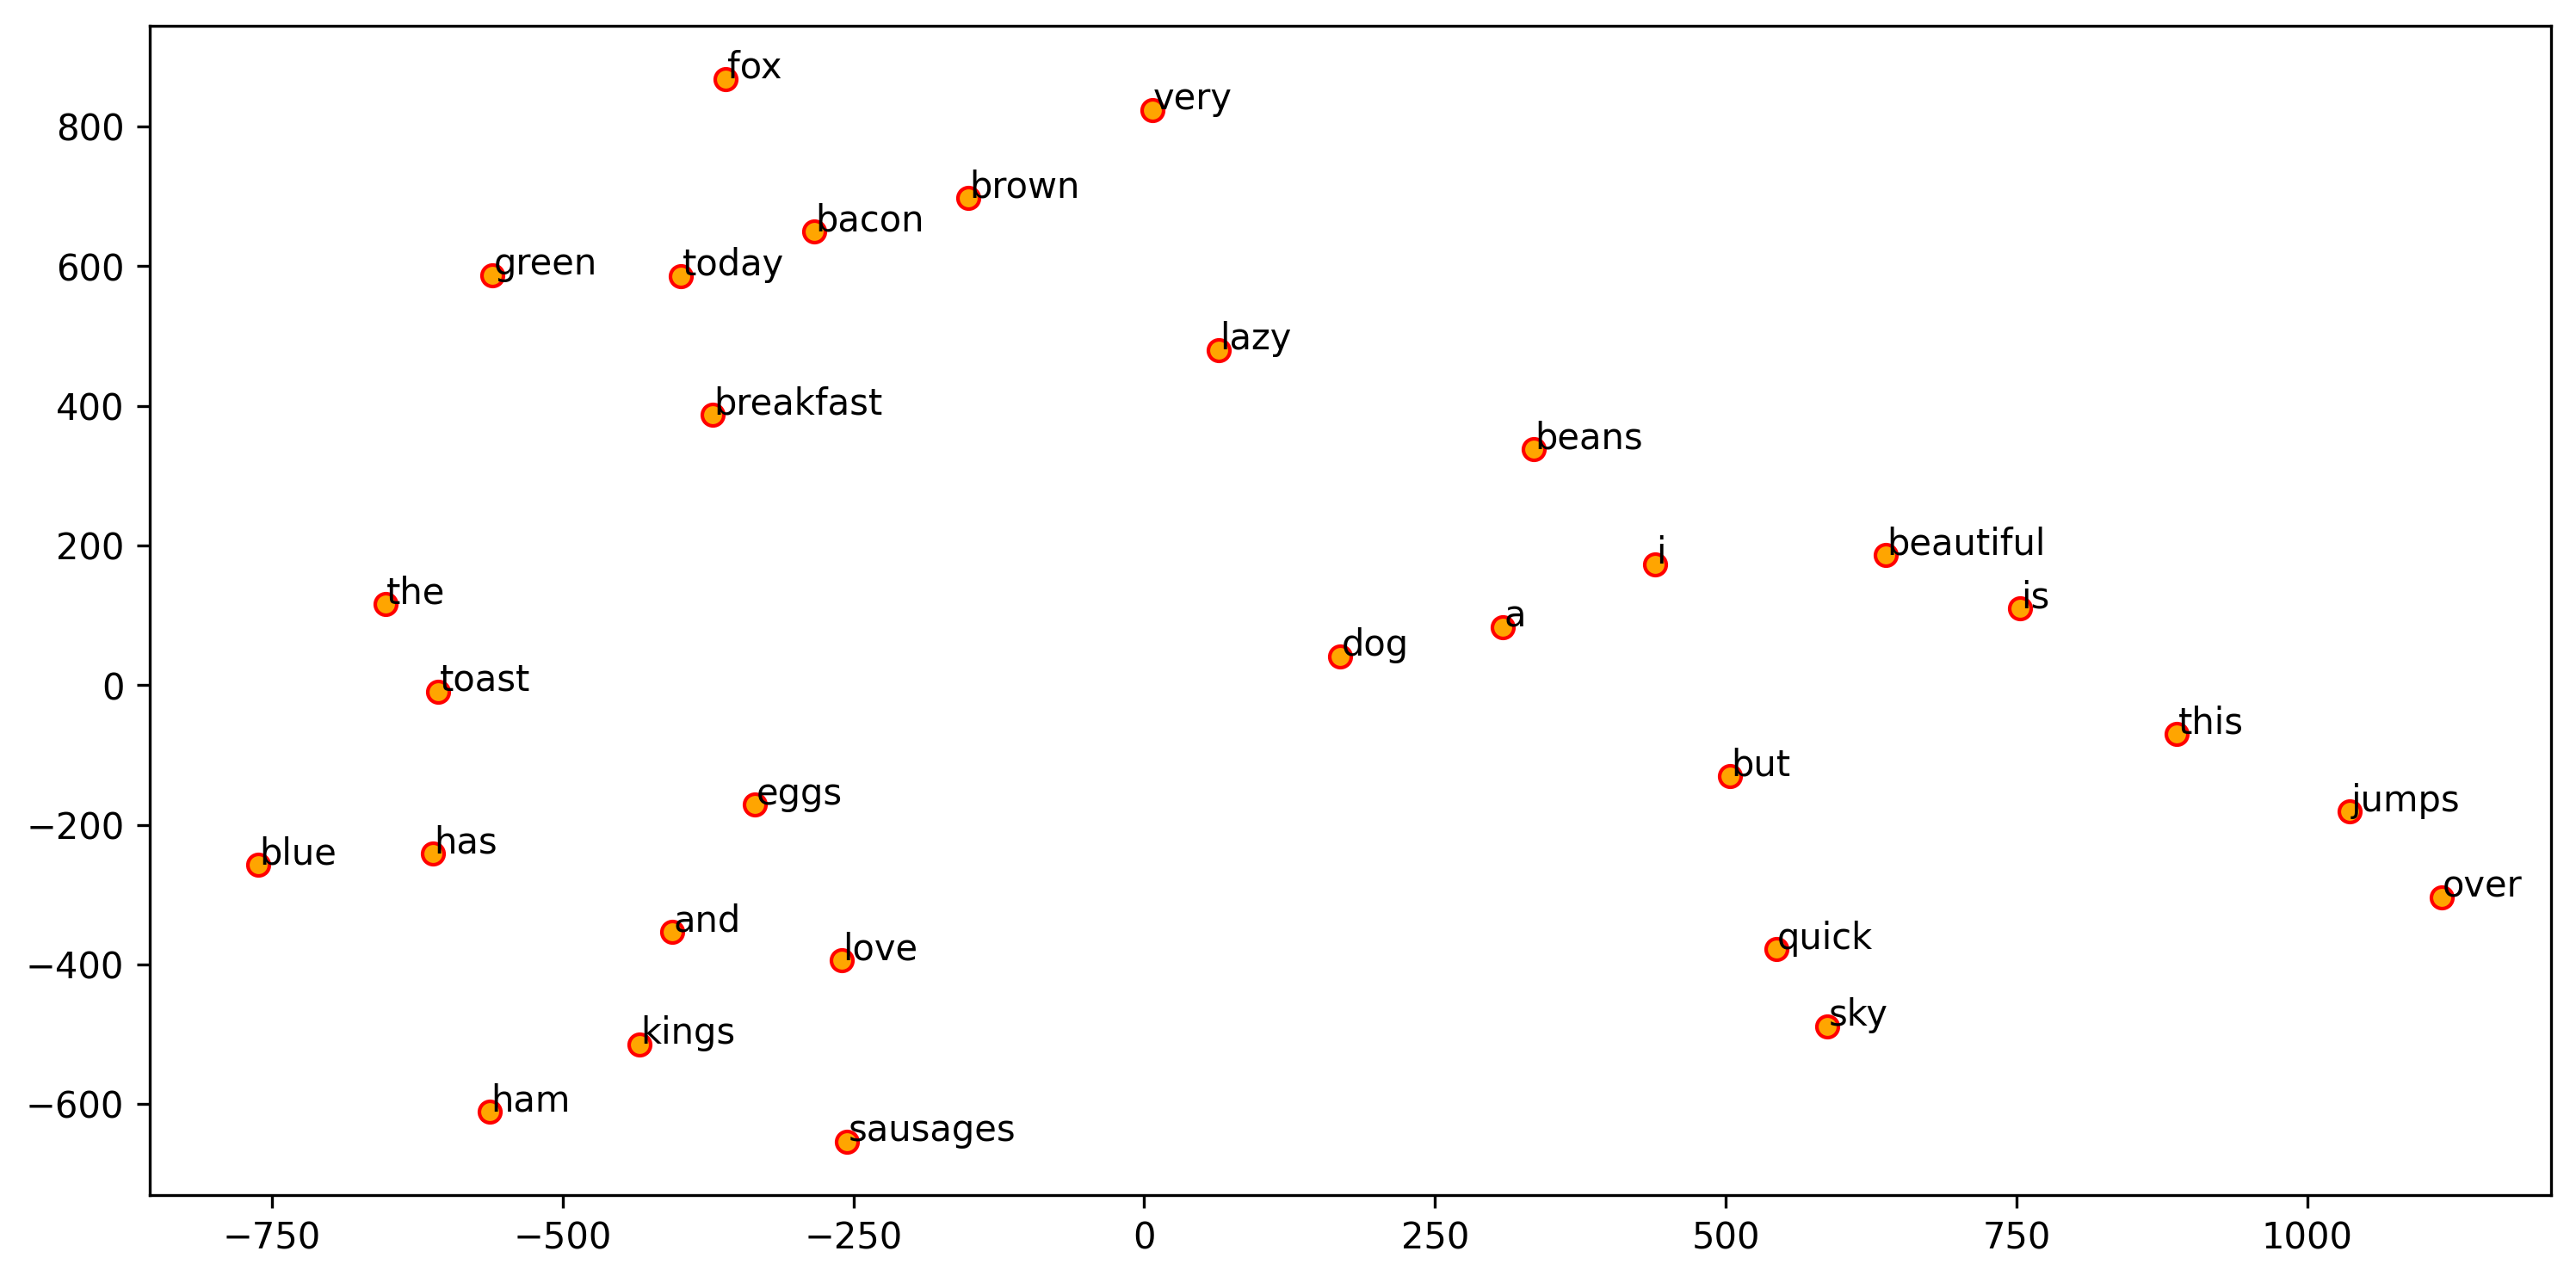

In [7]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word ## get the word forms of voculary
wvs = w2v_model.wv[words] ## get embeddings of all word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

- All trained word embeddings are included in `w2v_model.wv`.
- We can extract all word forms in the vocabulary from `w2v_model.wv.index2word`.
- We can easily extract embeddings for any specific words from `w2v_model.wv`.

In [8]:
w2v_model.wv.index2word[:5]

['the', 'is', 'and', 'sky', 'blue']

In [9]:
[w2v_model.wv[w] for w in w2v_model.wv.index2word[:5]]

[array([ 0.00939679,  0.06829984, -0.0175484 ,  0.02132299, -0.05242665,
        -0.03304851,  0.04419975, -0.06251208, -0.02399454,  0.09599195],
       dtype=float32),
 array([ 0.01285591,  0.03140358,  0.0112119 ,  0.018492  ,  0.03044026,
        -0.02544665, -0.0126411 , -0.05758382, -0.01122566, -0.00204952],
       dtype=float32),
 array([ 0.03643429,  0.0134499 , -0.03855488,  0.01903728, -0.03877831,
         0.02132287, -0.01270146, -0.02069955, -0.00287414,  0.08943592],
       dtype=float32),
 array([ 0.04386635, -0.03208053,  0.02133289, -0.01361762,  0.02044106,
         0.03751241, -0.02182892, -0.05563217, -0.01761477,  0.07301468],
       dtype=float32),
 array([ 0.05441866,  0.04495171, -0.05245401, -0.03693994,  0.00800954,
         0.01502647,  0.02184348, -0.06037745,  0.04196955,  0.07094096],
       dtype=float32)]

### From Word Embeddings to Document Embeddings

- With word embeddings, we can compute the **average embeddings** for the entire document, i.e., the ***document embeddings***.
- These document embeddings are also assumed to have included considerable semantic information of the document.
- We can for example use them for document classification/clustering.

In [10]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features, ), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [
        average_word_vectors(tokenized_sentence, model, vocabulary,
                             num_features) for tokenized_sentence in corpus
    ]
    return np.array(features)

In [11]:
w2v_feature_array = averaged_word_vectorizer(corpus=corpus_tokens,
                                             model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array, index=corpus_norm)

/Users/Alvin/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9
the sky is blue and beautiful,0.024933,0.027873,-0.014866,0.010272,0.000929,0.005070,-0.002073,-0.049160,-0.009556,0.055261
love this blue and beautiful sky,0.025177,0.008866,-0.019504,0.005455,0.010112,0.011062,-0.019272,-0.034388,-0.006778,0.058303
the quick brown fox jumps over the lazy dog,0.025583,0.018072,-0.004801,0.012446,-0.020033,0.009032,0.003629,-0.024342,-0.005160,0.043575
a kings breakfast has sausages ham bacon eggs toast and beans,0.031809,0.035237,-0.018374,0.027024,-0.036935,0.013074,0.008338,-0.014993,-0.001698,0.062499
i love green eggs ham sausages and bacon,0.022282,0.022551,-0.013670,0.024269,-0.031003,0.006596,-0.004233,-0.018123,-0.014158,0.066728
the brown fox is quick and the blue dog is lazy,0.022720,0.026896,-0.002897,0.013197,-0.018552,-0.000074,0.004398,-0.042001,-0.003830,0.048475
the sky is very blue and the sky is very beautiful today,0.020343,0.022317,-0.009557,0.016949,-0.008518,0.002390,0.008193,-0.049766,-0.004874,0.048264
the dog is lazy but the brown fox is quick,0.021527,0.021070,0.003986,0.017852,-0.018527,-0.004804,0.006598,-0.039903,-0.011737,0.034825


- Let's cluster these documents based on their **document embeddings**.

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

similarity_doc_matrix = cosine_similarity(w2v_feature_array)
similarity_doc_df = pd.DataFrame(similarity_doc_matrix)
similarity_doc_df

,0,1,2,3,4,5,6,7
0,1.000000,0.924964,0.907416,0.804161,0.843127,0.949765,0.973641,0.895263
1,0.924964,1.000000,0.817265,0.712207,0.798200,0.809972,0.845174,0.715360
2,0.907416,0.817265,1.000000,0.953124,0.953098,0.963551,0.927403,0.921641
3,0.804161,0.712207,0.953124,1.000000,0.961228,0.883486,0.829823,0.822652
4,0.843127,0.798200,0.953098,0.961228,1.000000,0.895851,0.849802,0.846301
5,0.949765,0.809972,0.963551,0.883486,0.895851,1.000000,0.978434,0.971061
6,0.973641,0.845174,0.927403,0.829823,0.849802,0.978434,1.000000,0.949926
7,0.895263,0.715360,0.921641,0.822652,0.846301,0.971061,0.949926,1.000000


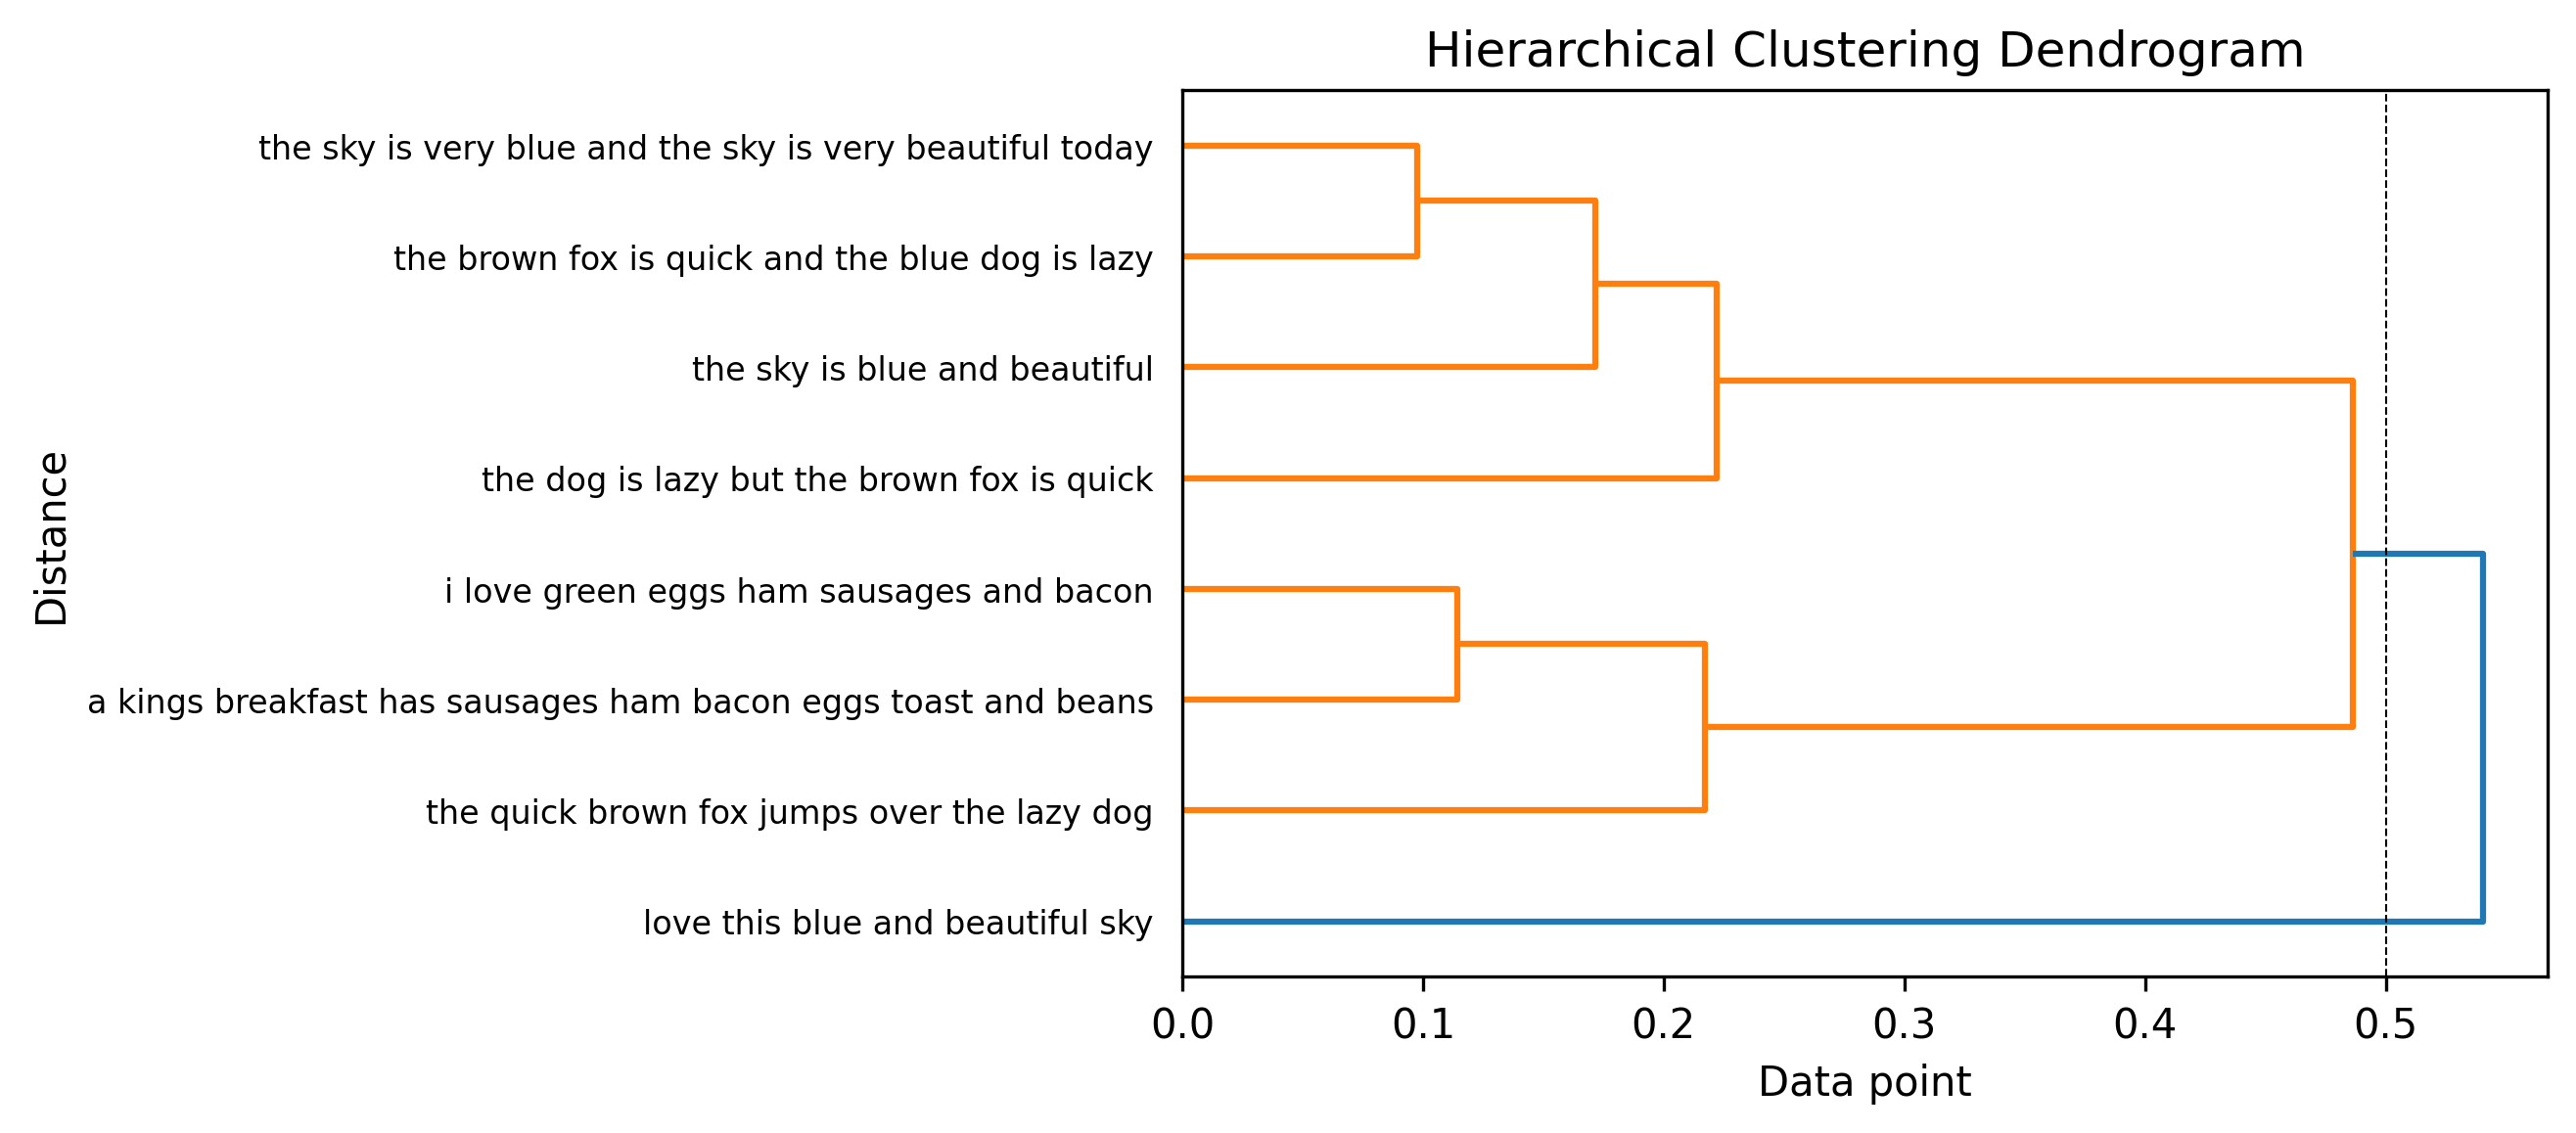

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_doc_matrix, 'ward')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z,
           labels=corpus_norm,
           leaf_rotation=0,
           leaf_font_size=8,
           orientation='right',
           color_threshold=0.5)
plt.axvline(x=0.5, c='k', ls='--', lw=0.5)

/Users/Alvin/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


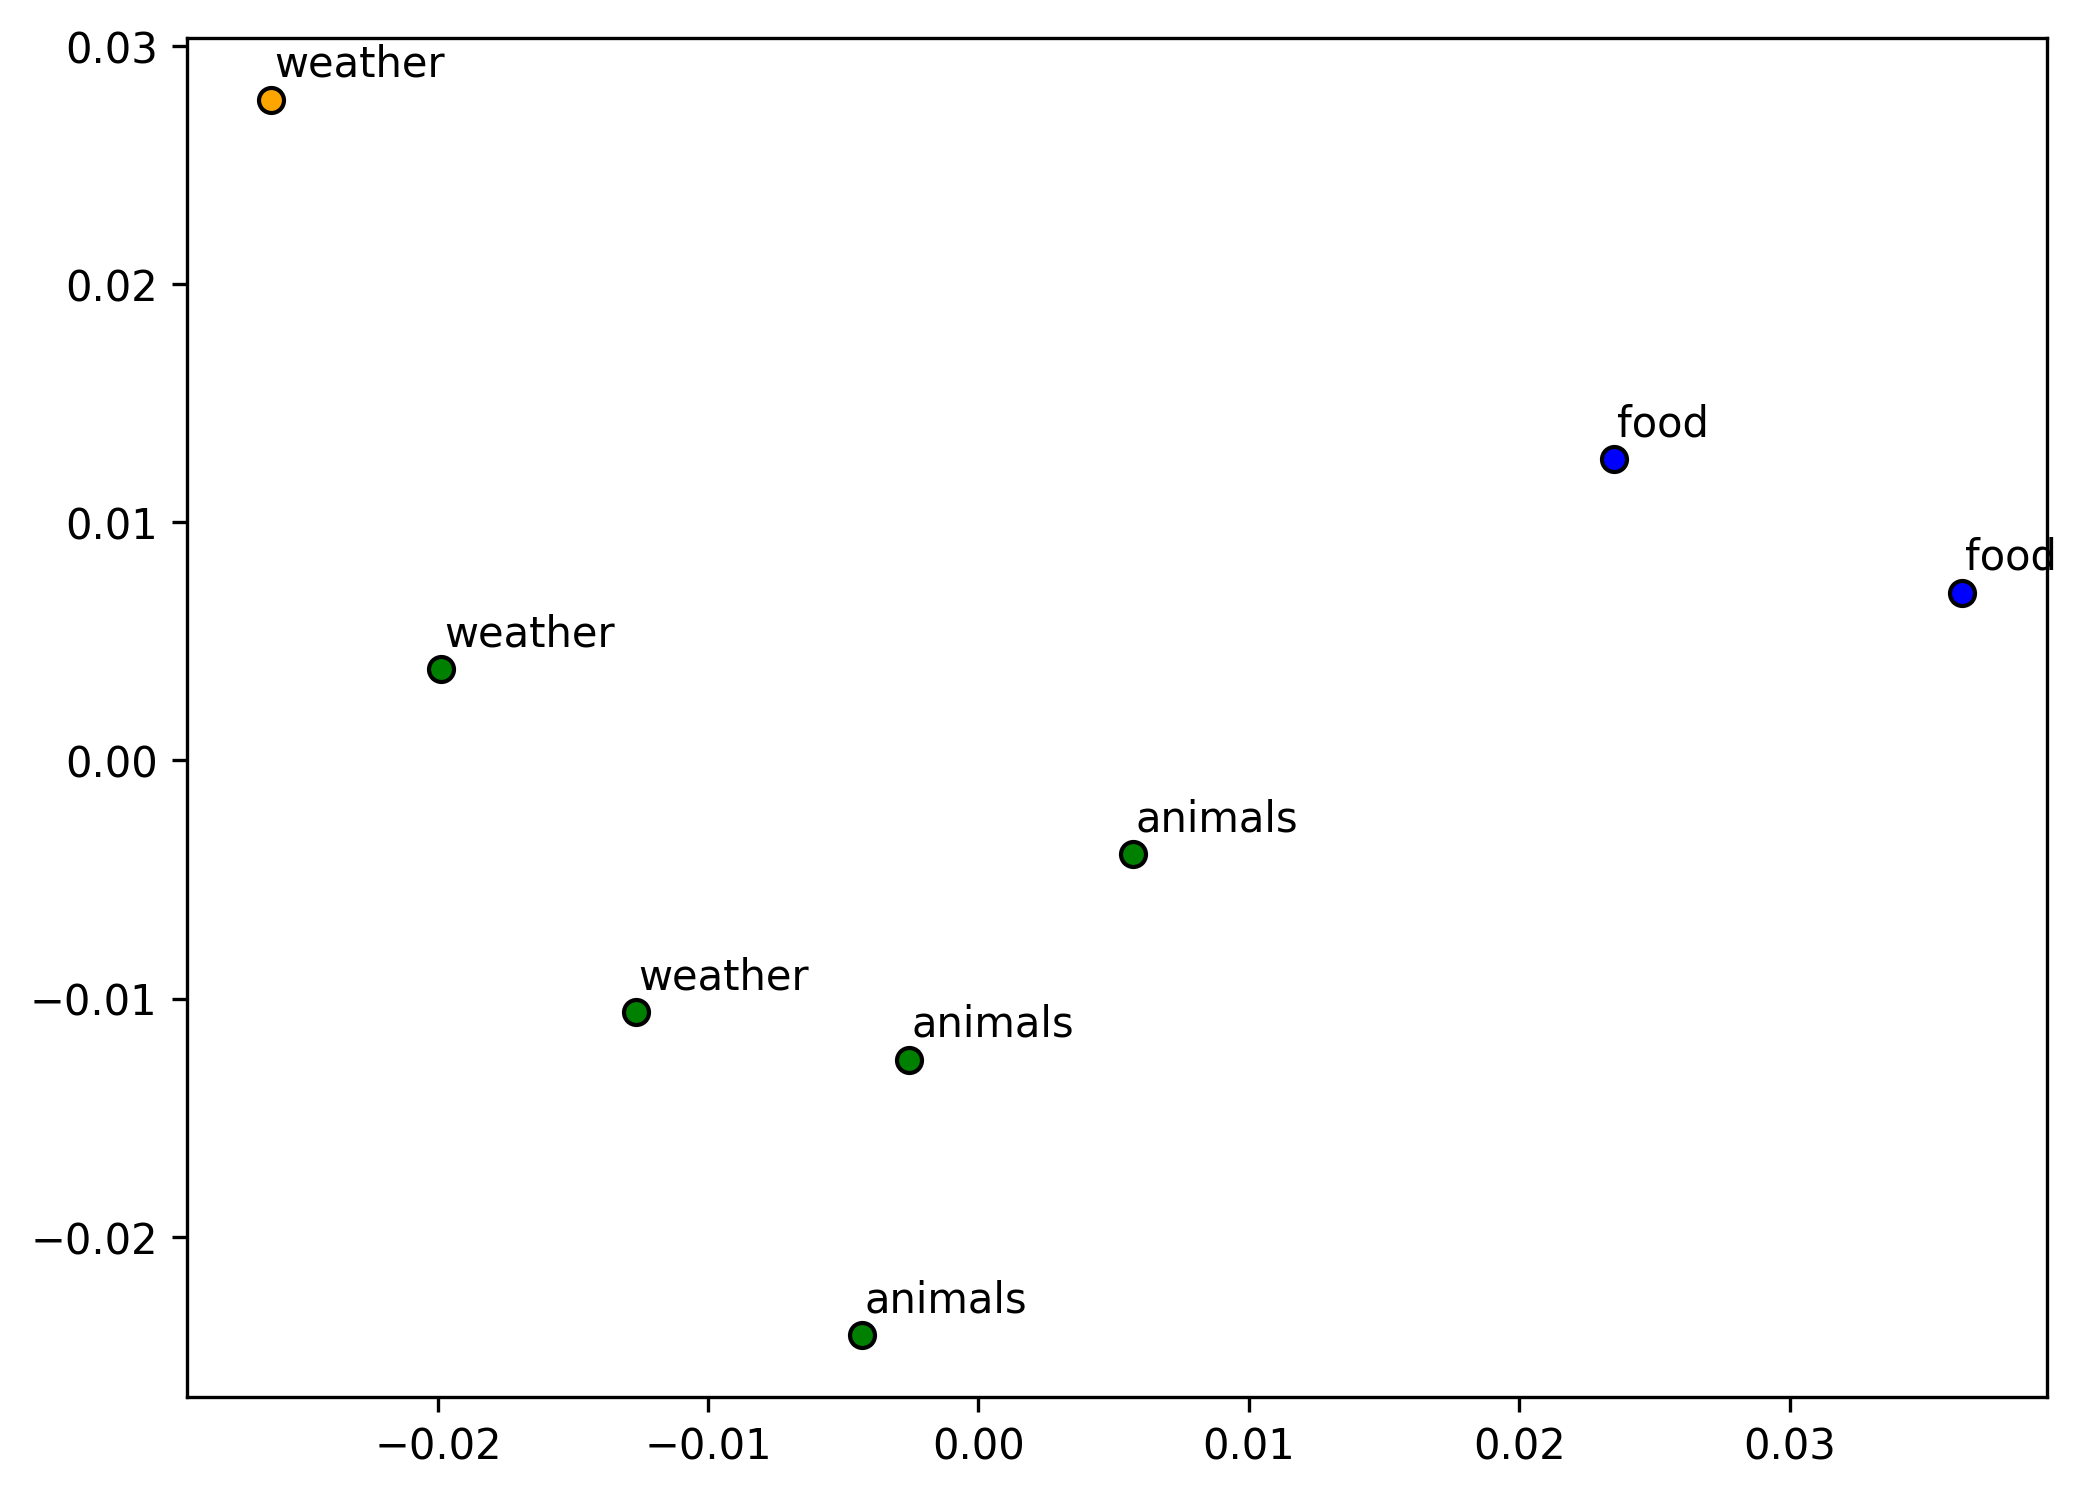

In [14]:
## Other Clustering Methods

from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

## PCA Plotting
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label,
                 xy=(x + 1e-4, y + 1e-3),
                 xytext=(0, 0),
                 textcoords='offset points')

## Using Pre-trained Embeddings:  GloVe in `spacy`

In [15]:
import spacy


nlp = spacy.load('en_core_web_lg',disable=['parse','entity'])

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 684830


In [16]:
print(spacy.__version__)

3.0.5


### Visualize GloVe word embeddings

- Let's extract the GloVe pretrained embeddings for all the words in our simple corpus.
- And we visualize their embeddings in a 2D plot via dimensional reduction.

:::{warning}
When using pre-trained embeddings, there are two important things:
- Be very careful of the **tokenization** methods used in your text preprocessing. If you use a very different word tokenization method, you may find a lot of **unknown** words that are not included in the pretrained model.
- Always check the **proportion of the unknown words** when vectorizing your corpus texts with pre-trained embeddings.
:::

In [17]:
# get vocab of the corpus
unique_words = set(sum(corpus_tokens,[]))

# extract pre-trained embeddings of all words
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
has,0.085520,0.501520,0.112660,-0.188260,0.031677,-0.071113,0.050192,-0.357280,-0.099622,2.83730,...,-0.271210,-0.062170,-0.007174,0.036467,0.261120,-0.189210,-0.052768,-0.155080,0.042269,0.014490
sky,0.312550,-0.303080,0.019587,-0.354940,0.100180,-0.141530,-0.514270,0.886110,-0.530540,1.55660,...,-0.667050,0.279110,0.500970,-0.277580,-0.143720,0.342710,0.287580,0.537740,0.363490,0.496920
today,-0.156570,0.594890,-0.031445,-0.077586,0.278630,-0.509210,-0.066350,-0.081890,-0.047986,2.80360,...,-0.326580,-0.413380,0.367910,-0.262630,-0.203690,-0.296560,-0.014873,-0.250060,-0.115940,0.083741
quick,-0.445630,0.191510,-0.249210,0.465900,0.161950,0.212780,-0.046480,0.021170,0.417660,1.68690,...,-0.329460,0.421860,-0.039543,0.150180,0.338220,0.049554,0.149420,-0.038789,-0.019069,0.348650
beans,-0.423290,-0.264500,0.200870,0.082187,0.066944,1.027600,-0.989140,-0.259950,0.145960,0.76645,...,0.048760,0.351680,-0.786260,-0.368790,-0.528640,0.287650,-0.273120,-1.114000,0.064322,0.223620
dog,-0.401760,0.370570,0.021281,-0.341250,0.049538,0.294400,-0.173760,-0.279820,0.067622,2.16930,...,0.022908,-0.259290,-0.308620,0.001754,-0.189620,0.547890,0.311940,0.246930,0.299290,-0.074861
kings,0.259230,-0.854690,0.360010,-0.642000,0.568530,-0.321420,0.173250,0.133030,-0.089720,1.52860,...,-0.470090,0.063743,-0.545210,-0.192310,-0.301020,1.068500,0.231160,-0.147330,0.662490,-0.577420
is,-0.084961,0.502000,0.002382,-0.167550,0.307210,-0.237620,0.160690,-0.367860,-0.058347,2.49900,...,0.087003,-0.078201,-0.069673,-0.169930,0.235980,0.275500,-0.067180,-0.215110,-0.263040,-0.006017
and,-0.185670,0.066008,-0.252090,-0.117250,0.265130,0.064908,0.122910,-0.093979,0.024321,2.49260,...,-0.593960,-0.097729,0.200720,0.170550,-0.004736,-0.039709,0.324980,-0.023452,0.123020,0.331200
breakfast,0.073378,0.227670,0.208420,-0.456790,-0.078219,0.601960,-0.024494,-0.467980,0.054627,2.28370,...,0.647710,0.373820,0.019931,-0.033672,-0.073184,0.296830,0.340420,-0.599390,-0.061114,0.232200


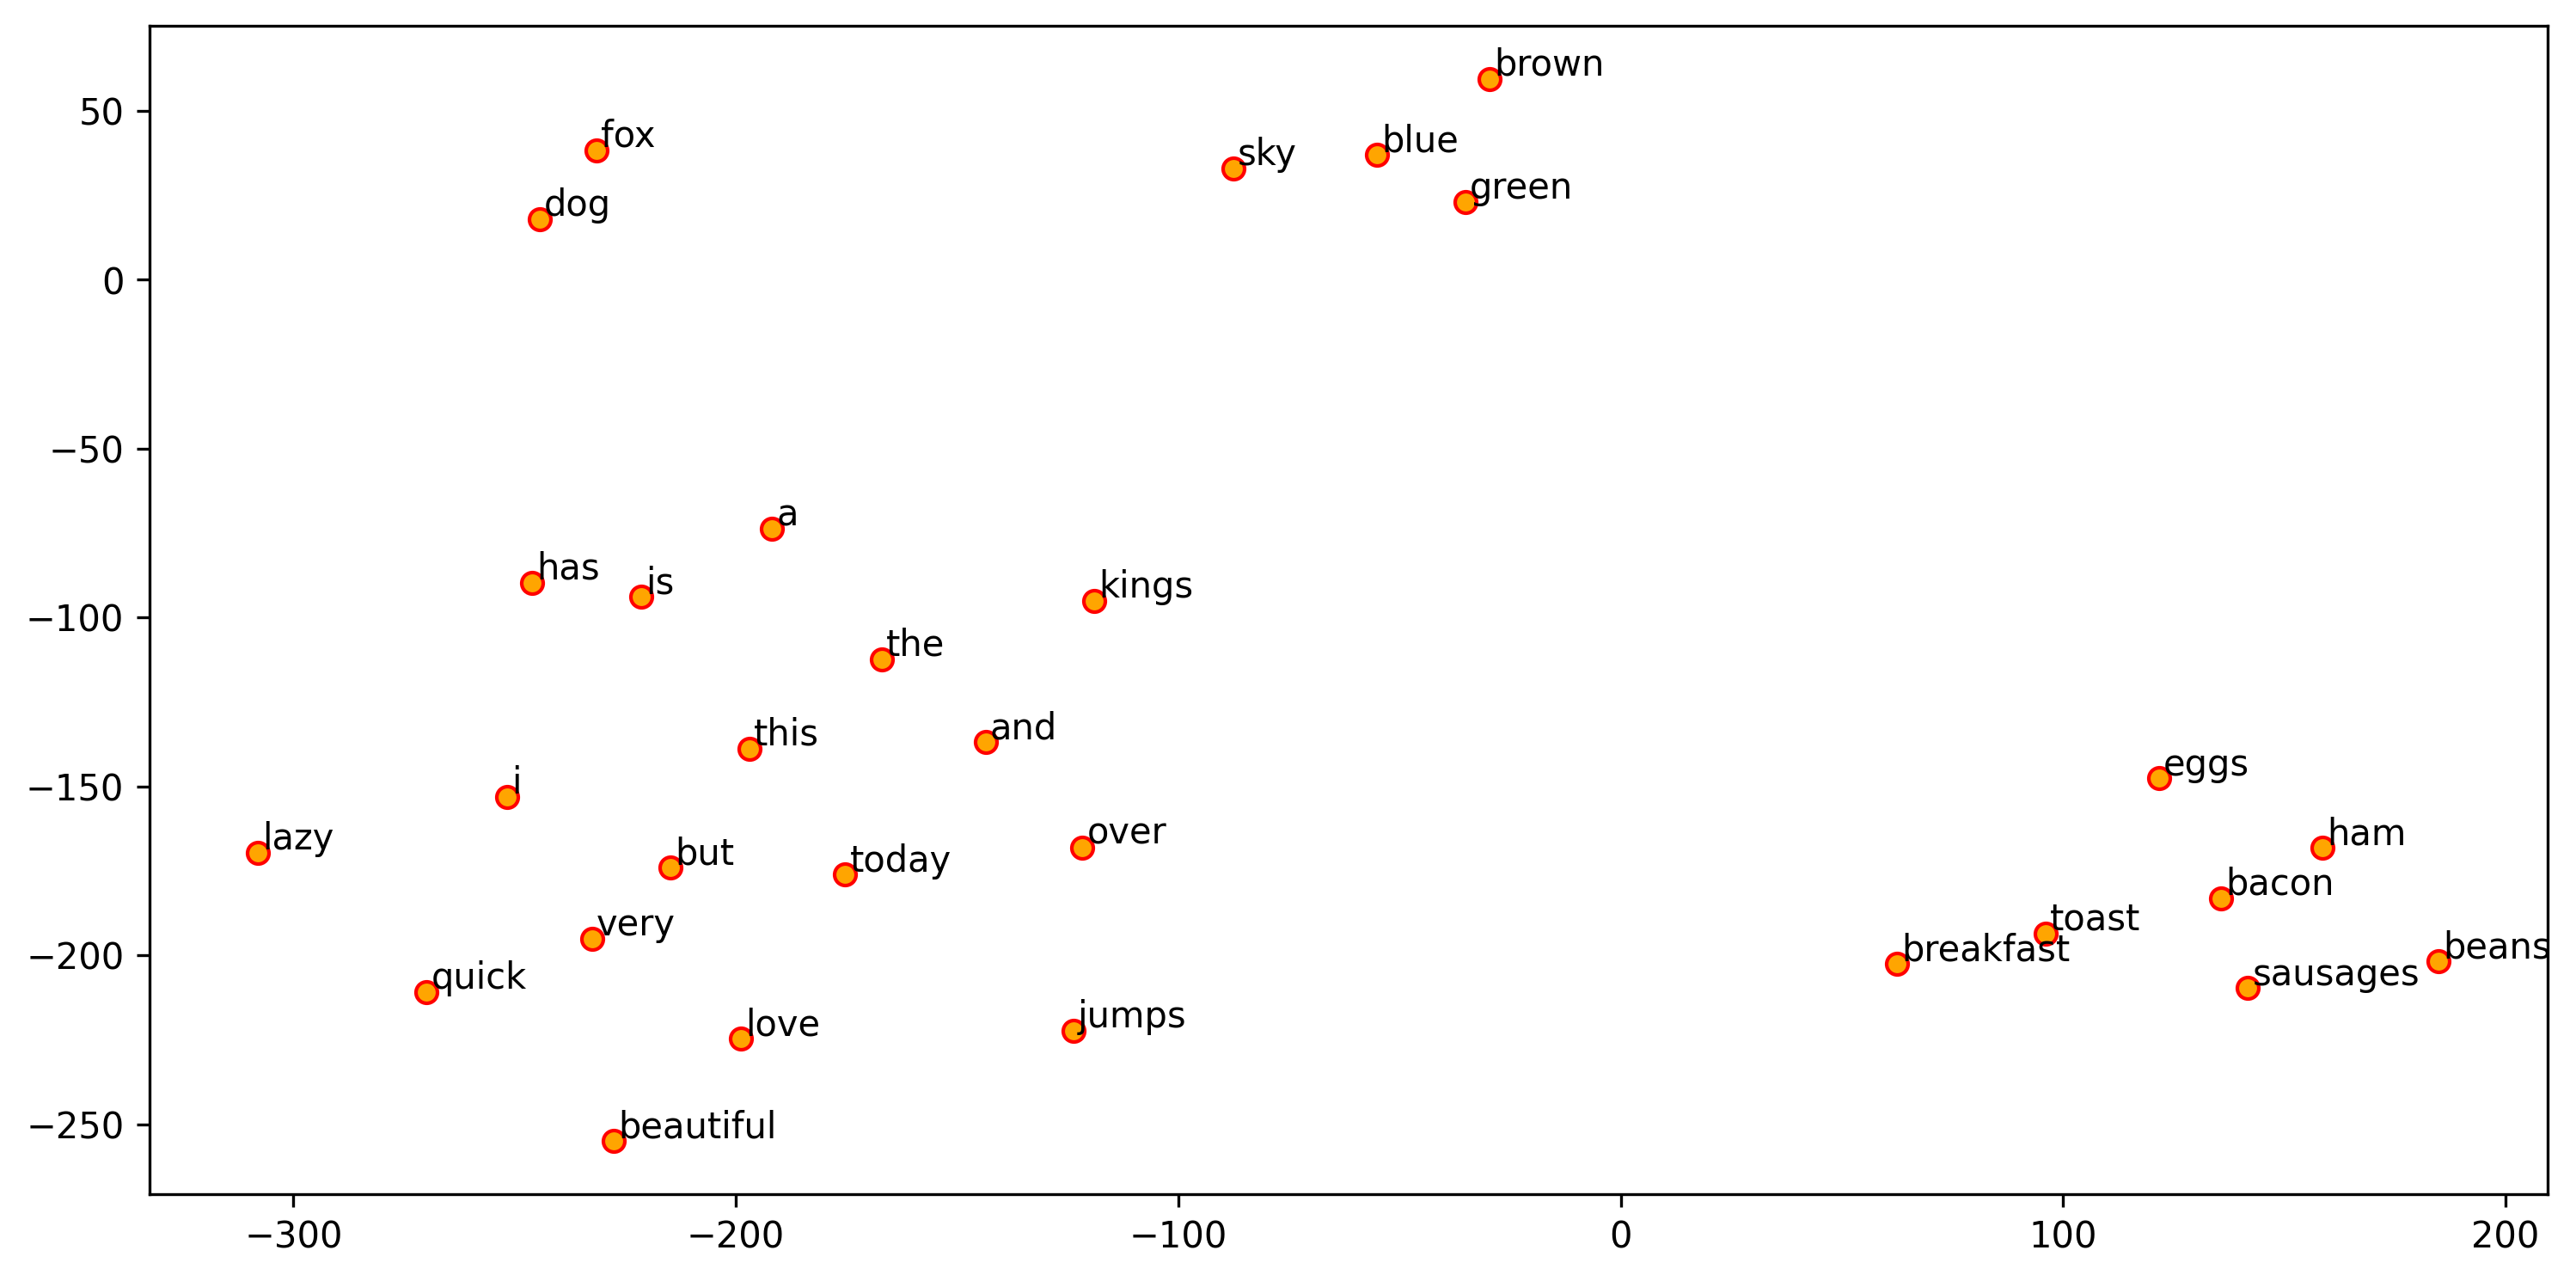

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')
    

- It is clear to see that when embeddings are trained based on a larger corpus, they reflect more lexical semantic contents.
- Semantically similar words are indeed closer to each other in the 2D plot.

- We can of course perform the document-level clustering again using the GloVe embeddings.
- The good thing about `spacy` is that it can compute the document average embeddings automatically.

In [19]:
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in corpus_norm])

import sklearn
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


## `fasttext`

- This section shows a quick example how to train word embeddings based on the `nltk.corpus.brown` using another algorithm, i.e., `fasttext`.
- The FastText model was introduced by Facebook in 2016 as an improved and extended version of the `word2vec` (See Bojanowski et al [2017] in References below).
- We will focus more on the implementation. Please see the Bojanowski et al (2017) as well as Sarkar (2019) Chapter 4 for more comprehensive descriptions of the method.
- Pretrained FastText Embeddings are available [here](https://fasttext.cc/docs/en/english-vectors.html).

In [20]:
from gensim.models.fasttext import FastText
from nltk.corpus import brown

brown_tokens = [brown.words(fileids=f) for f in brown.fileids()]

In [21]:
%%time
# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count

ft_model = FastText(brown_tokens,
                    size=feature_size,
                    window=window_context,
                    min_count=min_word_count,
                    sg=1,
                    iter=50)

CPU times: user 12min 19s, sys: 26.6 s, total: 12min 46s
Wall time: 5min 22s


- We can use the trained embeddings model to identify words that are similar to a set of seed words.
- And then we plot all these words (i.e., the seed words and their semantic neighbors) in one 2D plot based on the dimensional reduction of their embeddings.

In [22]:
# view similar words based on gensim's model
similar_words = {
    search_term:
    [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
    for search_term in
    ['think', 'say','news', 'report','nation', 'democracy']
}
similar_words

{'think': ['know', 'Think', 'tell', 'suppose', 'say'],
 'say': ['think', 'said', 'know', 'hear', 'want'],
 'news': ['forthcoming', 'Burr', 'newspapers', 'hailed', 'remarks'],
 'report': ['reports', 'Investigation', 'reporting', 'Report', "officer's"],
 'nation': ['nations', 'national', 'nationally', 'nationwide', 'nationalism'],
 'democracy': ['democratic',
  'cultural',
  'world',
  'capitalism',
  'Christianity']}

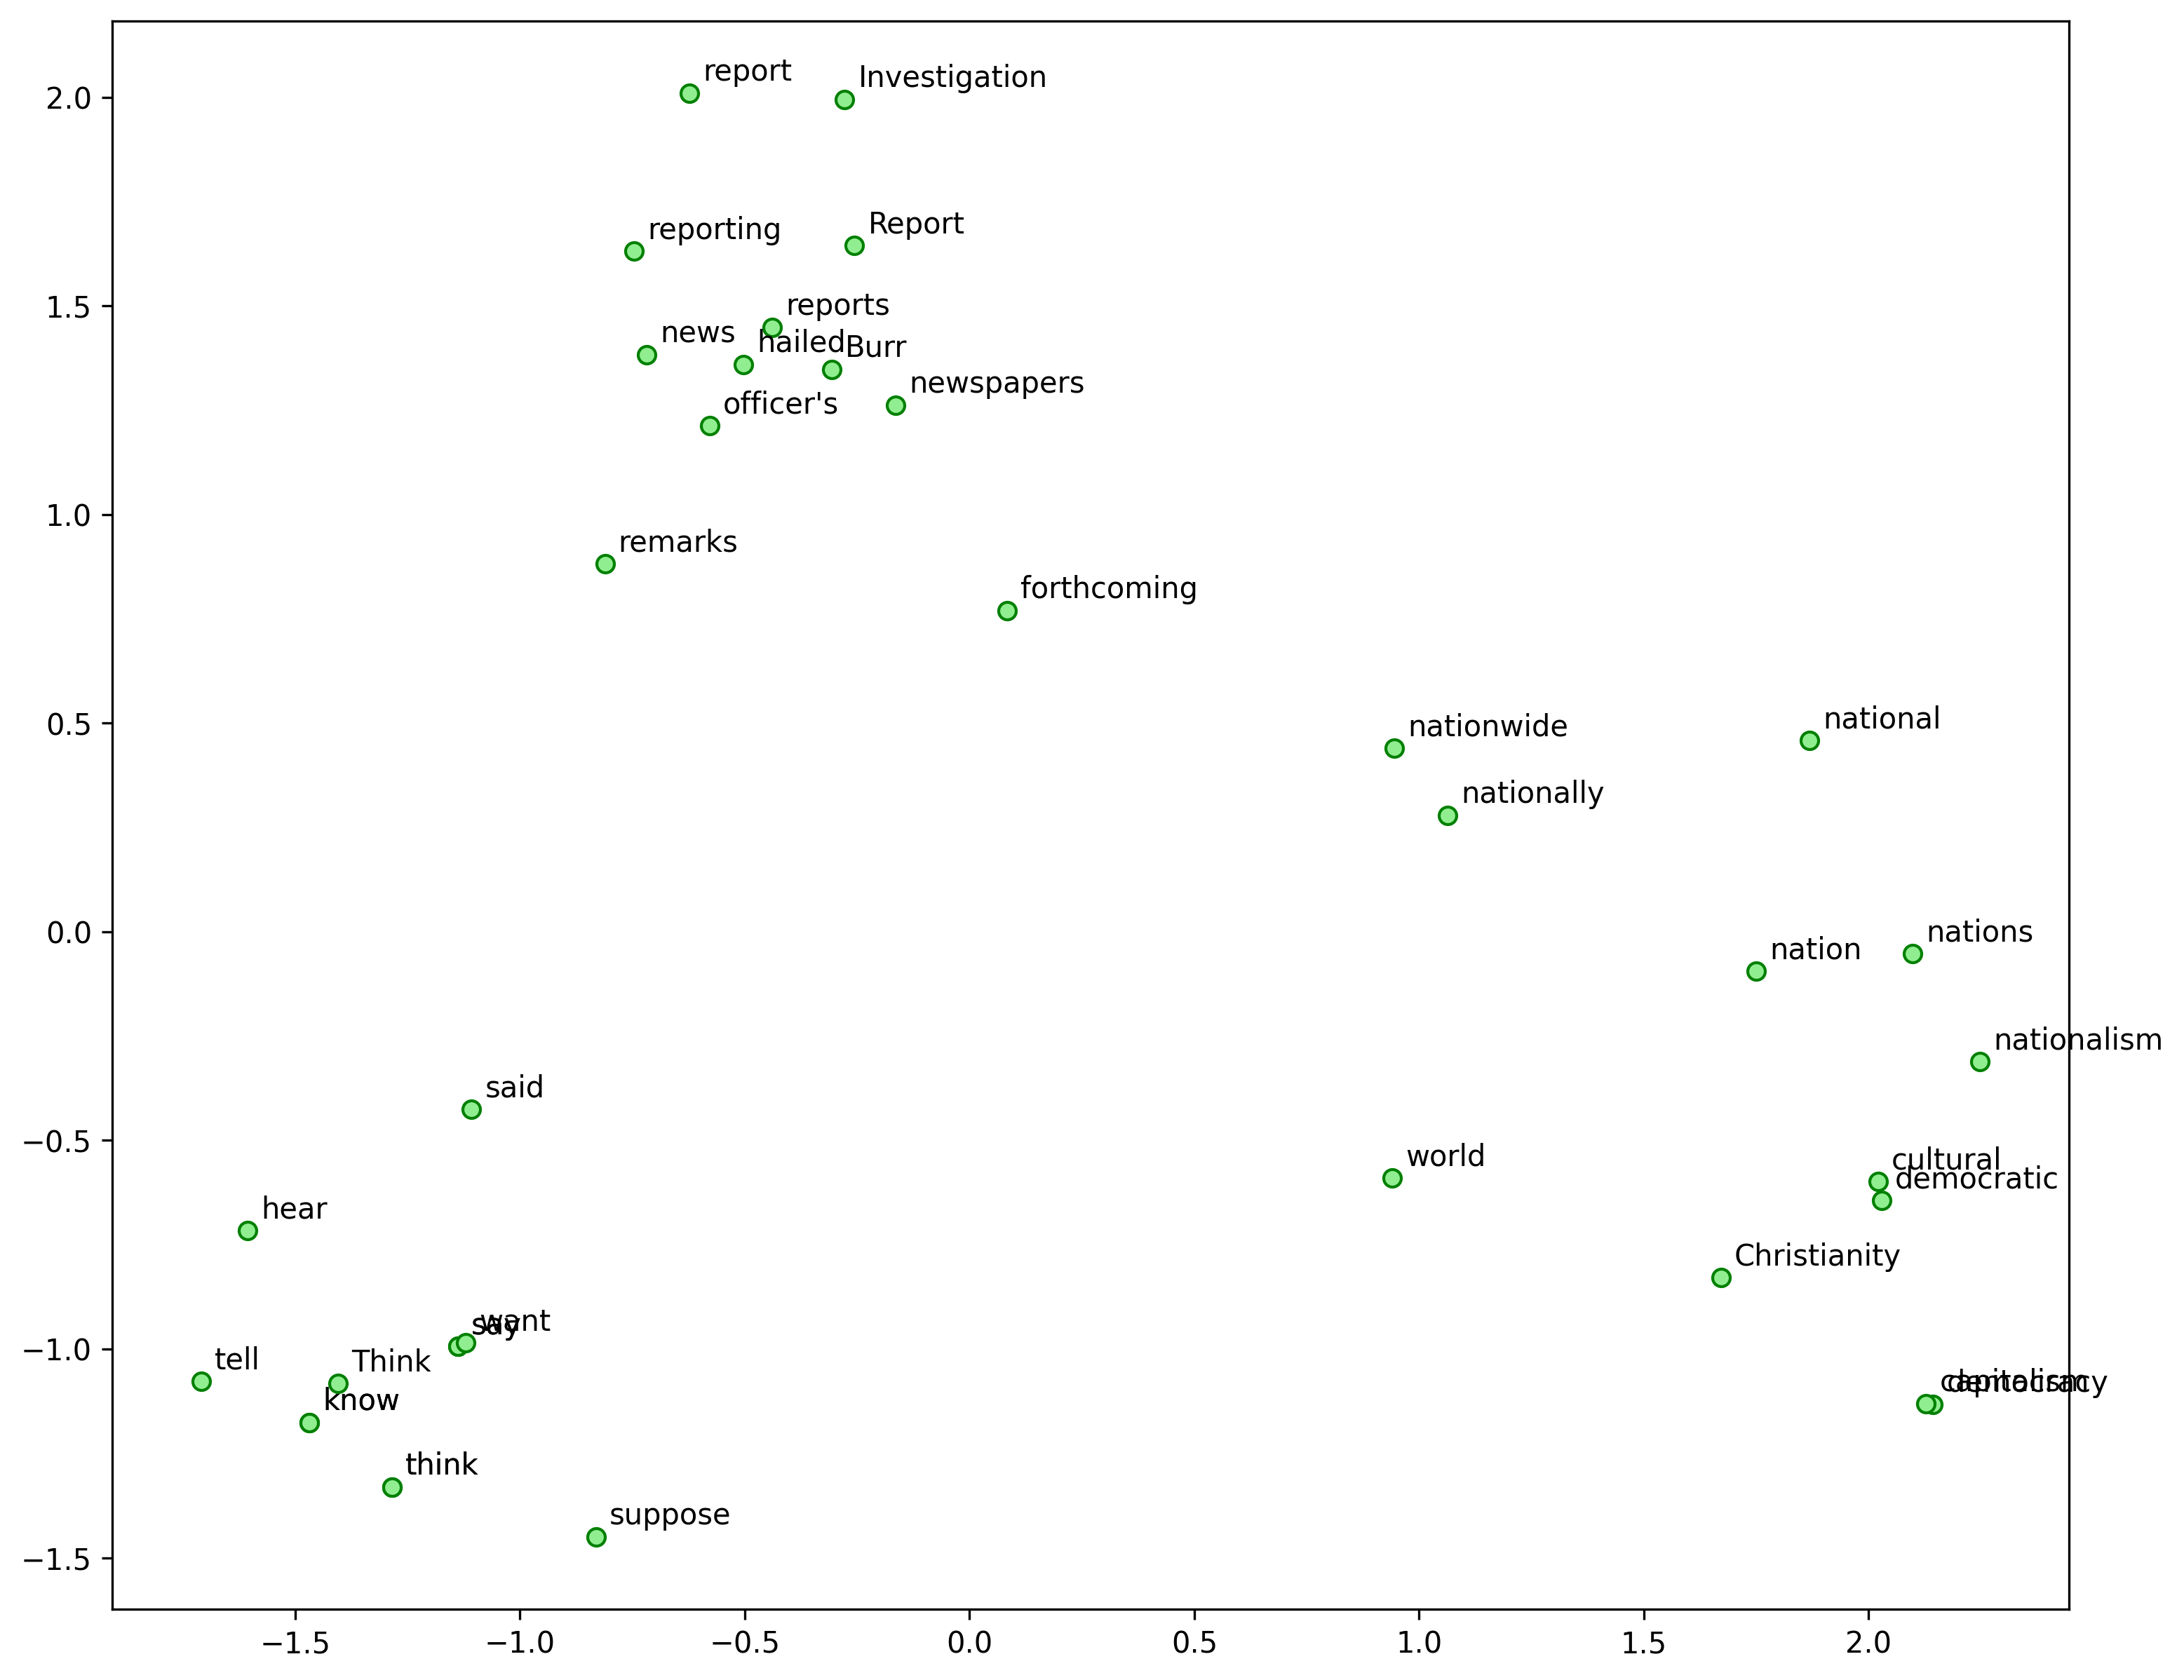

In [23]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label,
                 xy=(x + 0.03, y + 0.03),
                 xytext=(0, 0),
                 textcoords='offset points')

In [24]:
ft_model.wv['democracy']

array([ 0.6285441 , -0.38983855,  0.11425309,  0.06012838, -0.6053551 ,
       -0.16956608, -0.22312629, -0.10888387,  0.12648048, -0.07467075,
       -0.6946541 ,  0.21674407, -0.22717321,  0.4057445 ,  0.29266223,
        0.37295696, -0.08018252,  0.28890017, -0.21639867, -0.9471755 ,
       -0.0367635 , -0.04349962,  0.30649963, -0.55968153, -0.01258501,
       -0.5630713 ,  0.30955324,  0.32570282, -0.5851471 ,  0.7197201 ,
       -0.9000047 , -0.06964479,  0.28557375,  0.0619022 ,  0.3351349 ,
       -0.13018262,  0.02778896, -0.03295739, -0.5289631 , -0.21316352,
       -0.1927315 ,  0.35496324, -0.79570115,  0.02665308, -0.5433889 ,
       -0.27868316,  0.36585337, -0.25602865, -0.2014406 , -0.2385113 ,
       -0.9931128 , -0.05011513, -0.89226973, -0.09251308, -0.49075928,
        0.2526952 ,  0.17661068, -0.32355413,  0.30298945, -0.6417367 ,
       -0.96245843,  0.34119967,  0.50603724, -0.10167728,  0.37157422,
        0.27186954, -0.24821736,  0.33283603,  0.31510666, -0.47

In [25]:
print(ft_model.wv.similarity(w1='taiwan', w2='freedom'))
print(ft_model.wv.similarity(w1='china', w2='freedom'))

0.22647002
0.18219654


## Wrap-up

- Two fundamental deep-learning-based models of word representation learning: CBOW and Skip-Gram.
- From word embeddings to document embeddings
- More advanced representation learning models: GloVe and FastText.
- What is more challenging is how to assess the quality of the learned representations (embeddings). Usually embedding models can be evaluated based on their performance on semantics related tasks, such as word similarity and analogy. For those who are interested, you can start with the following two papers on Chinese embeddings:
    - Chi-Yen Chen, Wei-Yun Ma. 2018. "[Word Embedding Evaluation Datasets and Wikipedia Title Embedding for Chinese](http://www.lrec-conf.org/proceedings/lrec2018/pdf/159.pdf)," Language Resources and Evaluation Conference. 
    - Chi-Yen Chen, Wei-Yun Ma. 2017. "[Embedding Wikipedia Title Based on Its Wikipedia Text and Categories](https://ieeexplore.ieee.org/document/8300566)," International Conference on Asian Language Processing.


## References

- Sarkar (2020) Ch 4 Feature Engineering for Text Representation
- Major Readings:
    - Harris,Zellig. 1956. [Distributional structure](http://www.tandfonline.com/doi/pdf/10.1080/00437956.1954.11659520).
    - Bengio, Yoshuan, et. al. 2003. [A Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).
    - Collobert, Ronana and Jason Weston. 2008. [A Unified Architecture for Natural Language Processing: Deep Neural Networks with Multitask Learning](https://ronan.collobert.com/pub/matos/2008_nlp_icml.pdf).
    - Schwenk, Holger. 2007.[Continuous space language models](https://pdfs.semanticscholar.org/0fcc/184b3b90405ec3ceafd6a4007c749df7c363.pdf).
    - Mikolov, Tomas, et al. 2013. [Efficient estimation of word representations in vector space](https://arxiv.org/abs/1301.3781). arXiv preprint arXiv:1301.3781. 
    - Mikolov, Tomas, et al. 2013. [Distributed representations of words and phrases and their compositionally](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). *Advances in neural information processing systems*. 2013.
    - Baroni, Marco, et. al. 2014. [Don’t count, predict! A systematic comparison of context-counting vs. context-predicting semantic vectors](https://www.aclweb.org/anthology/P14-1023/). *ACL*(1).
    - Pennington, Jeffrey, et al. 2014. [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf). *EMNLP*. Vol. 14.
    - Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). [Enriching word vectors with subword information](https://doi.org/10.1162/tacl_a_00051). *Transactions of the Association for Computational Linguistics*, 5, 135-146.
- [GloVe Project Official Website](https://nlp.stanford.edu/projects/glove/): You can download their pre-trained GloVe models.
- [FastText Project Website](https://fasttext.cc/docs/en/english-vectors.html): You can download the English pre-trained FastText models.
